<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/model-sampling-reppen-v0/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [2]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub
!pip install --upgrade tensorflow
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1491b1023e1895f904940887d68004312033eafa2015f54971f5d7f54fa1fac8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully u

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


## Libraries

In [1]:
# LIBRARIES

import os
import pandas as pd
import numpy as np
import json
import shutil

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import History

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, pipeline
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge')

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-1-05b269de8445>:36: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

## Logins, Paths and Auxiliar Functions

In [2]:
# Connect w/ HuggingFace HUB
from huggingface_hub import notebook_login
notebook_login()

In [2]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# PATHS
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/"

documents = os.listdir(BASE_PATH)

Mounted at /content/drive/


In [3]:
# AUXILIAR FUNCTIONS

# Function to convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell



# Function to join all the sentences of input document
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data




# Define the metric to use (ROUGE Scores)
def metric_fn(eval_predictions):
  predictions, labels = eval_predictions

  for prediction in predictions:
      prediction[prediction < 0] = tokenizer.pad_token_id  # Replace masked prediction tokens

  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )

  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

## Preprocess Data

In [4]:
data = pd.read_csv(BASE_PATH+'Data/Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.head(5)

,source,paper_id,target,title,number_words_target,extractive_summary
0,Due to the success of deep learning to solving...,SysEexbRb,We provide necessary and sufficient analytical...,NaN,38,We are interested in the square loss function ...
1,Generative Adversarial Networks (GANs) have ac...,ryj38zWRb,Are GANs successful because of adversarial tra...,NaN,36,"On the one hand, a generator plays to transfor..."
2,Dialogue systems require a great deal of diffe...,BJepraEFPr,"In this paper, we propose to learn a dialogue ...",NaN,30,"However, several problems arise with this impl..."
3,Backdoor attacks aim to manipulate a subset of...,rkgyS0VFvr,We proposed a novel distributed backdoor attac...,NaN,35,"Compared to standard centralized backdoors, we..."
4,The integration of a Knowledge Base (KB) into...,SJl7tREFvr,Conventional memory networks generate many red...,NaN,32,Given the large amount of dialogue data record...


In [5]:
# Count number of words of source and target
def count_words(column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words('target')
data['number_words_source'] = count_words('source')
data['number_words_extractive'] = count_words('extractive_summary')

In [6]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    1312.000000
mean       58.935213
std        20.402388
min        30.000000
25%        41.000000
50%        58.000000
75%        73.000000
max       149.000000
Name: number_words_target, dtype: float64
count     1312.000000
mean      5177.437500
std       2107.094236
min        126.000000
25%       4069.750000
50%       5001.500000
75%       6187.750000
max      24589.000000
Name: number_words_source, dtype: float64
count    1312.000000
mean      621.176067
std       143.951058
min       126.000000
25%       534.000000
50%       611.000000
75%       693.000000
max      1199.000000
Name: number_words_extractive, dtype: float64


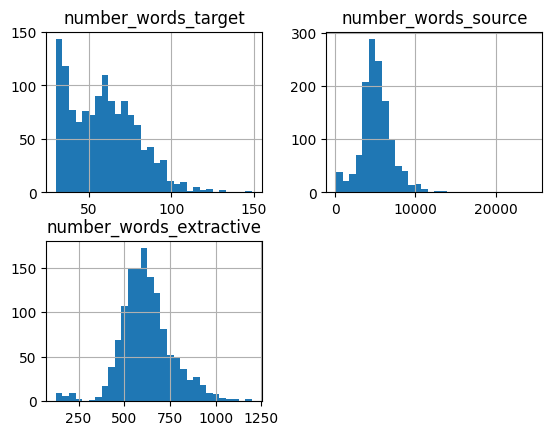

In [7]:
# Histogramas
data.hist(bins=30)
plt.show()

In [8]:
data = data[data['number_words_target']>=40].reset_index(drop=True)
data['number_words_target'].describe()

count    1012.000000
mean       66.381423
std        17.169049
min        40.000000
25%        54.000000
50%        64.000000
75%        77.000000
max       149.000000
Name: number_words_target, dtype: float64

## BART



#### Prepare Data for Tokenization

In [9]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        random_state=42)

In [10]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(647, 8) (162, 8) (809, 8) (203, 8)


In [11]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

In [12]:
# Tokenize data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', errors='ignore')

# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(text=data['extractive_summary'], text_target=data['target'], max_length=max_input_length, truncation=True)
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/647 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [13]:
# eval_dataset = generation_dataset

In [14]:
# main_input_name=getattr(model, "main_input_name", "input_ids")

In [16]:
# prediction_list = []
# i=0

# for batch in eval_dataset:
#   i = i+1
#   if isinstance(batch, tuple):
#     batch, labels = batch

#     generation_inputs = batch[main_input_name]
#     attention_mask = batch.get("attention_mask", None)
#     print(f'batch numero {i}')
#     print(batch)
#     predictions = model.generate(
#                         generation_inputs, attention_mask=attention_mask
#                     )
#     prediction_list.append(predictions)


In [17]:
# isinstance(inputs[0], tf.Tensor)

In [18]:
# inputs = prediction_list
# padding_index=-100
# batches=[tensor.numpy() for tensor in inputs]
# batches[0].ndim == 1 or all(batch.shape[1] == batches[0].shape[1] for batch in batches)

In [19]:
# max_len = max([batch.shape[1] for batch in batches])
# num_samples = sum([batch.shape[0] for batch in batches])
# output = np.full_like(
#     batches[0], fill_value=padding_index, shape=[num_samples, max_len] + list(batches[0].shape[2:])
# )
# # i keeps track of which part of the concatenated array we're writing the next batch to
# i = 0
# for batch in batches:
#   output[i : i + len(batch), : batch.shape[1]] = batch
#   i += len(batch)

In [20]:
# all_preds = output
# predictions = all_preds
# decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
# predictions
# token_ids = list(predictions[0])
# token_ids

In [21]:
# skip_special_tokens=True
# token_ids = list(predictions[0])
# token_ids

### Prepare Data for Training

In [ ]:
# Load BART Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

model.generation_config.max_length = 150
# model.generation_config.min_length = 50
model.generation_config.length_penalty = 2
model.generation_config.num_beams = 4

model.generation_config.do_sample = True
model.generation_config.temperature = 0.5

model.generation_config.repetition_penalty = 1.2

model.config.attention_dropout = 0.2

use_XLA = False
if use_XLA:
  model.generation_config.no_repeat_ngram_size = 0 # In order to use XLA Generation

name_model = 'sampling-norep-v0/'

print(model.generation_config)


batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 150,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.2,
  "temperature": 0.5
}



In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

if use_XLA:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)
else:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

In [ ]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [ ]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(100):  # Take the first batch for inspection
    print(batch[0])

Se han truncado las últimas 5000 líneas del flujo de salida.
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1],
       [    2,     0,   170,   304,  1707,  7373,     7,  8286,  5808,
        29997,  8047,     6,     8,    84,   275,  2967, 29997,  5043,
            6,   856,  1640,  1178,    43,  5457,  3023,  1009,   579,
        35045, 12572,  1640, 44263,  1009,  3023,   238,  9980, 33334,
         1223, 39826,    15,    10,   346,     9,  4087,  8558,   101,
         2960, 15721,     4,  1698, 38395,    10, 37700,  2239,   716,
         1548,    13,  2609,   786,    12, 43871,  1571,    30,  6062,
          149, 21092,    31,    10,   278,     9,   542,  1766,     8,
        32771,  5990,     4,   152,  2225, 33778, 37700,  2239, 

In [ ]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [ ]:
save_path = BASE_PATH + '/Results/TLDR/BART/model_save/' + name_model

In [ ]:
#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True,
    use_xla_generation=use_XLA
)

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./model_save",
#     tokenizer=tokenizer,
#     hub_model_id="iguerrasevillano/BART-summ-v1",
#     save_strategy='epoch',
#     checkpoint=True
# )


checkpoint_callback = ModelCheckpoint(
    filepath=save_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
resume = False
epochs = 10

callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early,
             checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

# Save the model and tokenizer to a directory
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

[INFO: fine-tuning model...]
Epoch 1/10
81/81 [==============================] - 4258s 53s/step - loss: 3.8318 - val_loss: 3.3432 - rouge1: 39.1278 - rouge2: 11.4287 - rougeL: 23.8929 - rougeLsum: 32.8663 - gen_len: 78.2778
Epoch 2/10
81/81 [==============================] - 3674s 46s/step - loss: 3.4892 - val_loss: 3.2677 - rouge1: 39.9013 - rouge2: 11.8156 - rougeL: 24.4284 - rougeLsum: 33.4198 - gen_len: 78.9938
Epoch 3/10
81/81 [==============================] - 3602s 45s/step - loss: 3.3123 - val_loss: 3.2453 - rouge1: 39.5973 - rouge2: 11.8269 - rougeL: 24.3736 - rougeLsum: 33.1367 - gen_len: 72.3889
Epoch 4/10
81/81 [==============================] - 3507s 44s/step - loss: 3.1602 - val_loss: 3.2332 - rouge1: 40.2346 - rouge2: 11.8346 - rougeL: 24.3682 - rougeLsum: 33.6911 - gen_len: 74.6420
Epoch 5/10
81/81 [==============================] - 3504s 44s/step - loss: 3.0304 - val_loss: 3.2358 - rouge1: 40.4387 - rouge2: 12.4221 - rougeL: 24.8456 - rougeLsum: 34.1460 - gen_len: 73.6

('/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/tokenizer_config.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/special_tokens_map.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/vocab.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/merges.txt',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/added_tokens.json')

In [38]:
with open(save_path + 'training_history.json', 'w') as file:
    json.dump(history, file)

TypeError: Object of type History is not JSON serializable

In [46]:
# List all files in the source folder
weights_last_epoch = '/tf_model.h5'

source_file_path = os.path.join(save_path, weights_last_epoch)
destination_file_path = os.path.join(save_path + '/last_epoch', weights_last_epoch)
shutil.move(source_file_path, destination_file_path)

print(f"File {weights_last_epoch} moved from {source_file_path} to {destination_file_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/tf_model.h5'

In [47]:
# Change name
original_path = save_path + '/weights.h5'
new_name = 'tf_model.h5'

# Create the new file path
new_path = os.path.join(os.path.dirname(original_path), new_name)

# Rename the file
os.rename(original_path, new_path)

print(f"File weights.h5 renamed as {new_name}")

File weights.h5 renamed as tf_model.h5


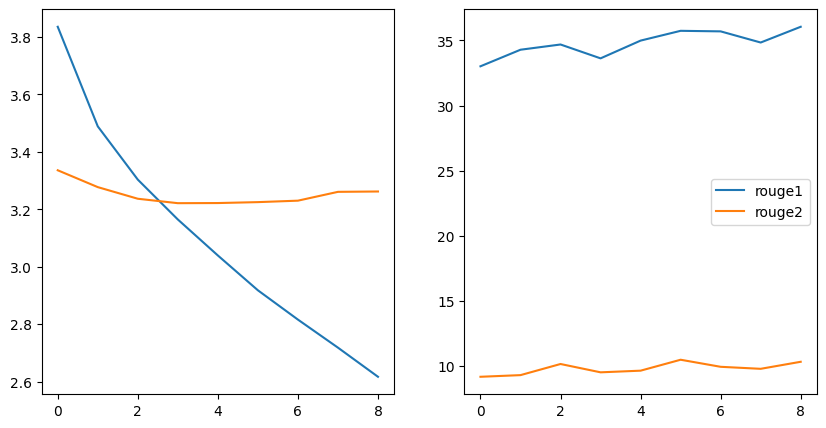

In [30]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    plt.legend()

plot_graphics(H)
plt.savefig(save_path + '/figure.png')

### Evaluation

In [14]:
name_models = {'sampling-norep' : 'sampling-norep-v0/'}
save_paths = {}
models = {}
# tokenizers = {}

for name in name_models:
  save_paths[name] = BASE_PATH + '/Results/TLDR/BART/model_save/' + name_models[name]

  models[name] = TFAutoModelForSeq2SeqLM.from_pretrained(save_paths[name])
  # tokenizers[name] = BartTokenizer.from_pretrained(save_path[name])
  print(models[name].generation_config)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 150,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.2,
  "temperature": 0.5
}



In [ ]:
name = 'sampling-norep'
save_path = save_paths[model]

with open(save_path + '/training_history.json', 'r') as file:
    loaded_history = json.load(file)

H = History()
H.history = loaded_history


def plot_graphics(H):
    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    plt.legend()

plot_graphics(H)
plt.savefig(save_path + '/figure.png')

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 150,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.2,
  "temperature": 0.5
}

In [15]:
name = 'sampling-norep'

In [16]:
models[name].generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 150,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.2,
  "temperature": 0.5
}

In [49]:
generated_summaries = []
accumulated_metrics = {}

n = len(tokenized_data['test']['input_ids'])
batch_size = 2 # Must be greater than 1
n=3

# Last batch is dropped (just one sample if batch_size=2) to average ROUGE scores properly
for i in range(0, n-1, batch_size):
  print(f'[INFO]: batch number {i}')


  generated_ids = models[name].generate(tokenized_data['test']['input_ids'][i:i+batch_size],
                                        generation_config=models[name].generation_config,
                                        seed=42)
  reference_labels = np.array(tokenized_data['test']['labels'][i:i+batch_size])

  predicted_labels = np.array(generated_ids)

  current_metrics = metric_fn((predicted_labels, reference_labels))
  accumulated_metrics = {k : current_metrics.get(k, 0) + accumulated_metrics.get(k, 0) for k in current_metrics.keys()}

  # Predicted summaries
  generated_summaries.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))


real_metrics = {k : accumulated_metrics.get(k, 0)/len(range(0, n-1, batch_size)) for k in accumulated_metrics.keys()}

[INFO]: batch number 0


In [51]:
generated_summaries

[['We propose a variational Dirichlet framework for deep neural network classification and define a higher-order uncertainty measure. The paper proposes a new uncertainty measure that can be used to detect in-and out-of-distribution examples. This paper proposes to use the Dirichlets framework to improve the accuracy of deep neural networks in image classification.',
  'We investigate the contribution of individual neurons to NMT models. This paper proposes a novel translation control method for neural networks, based on the idea that they can be used to control the translation of language pairs. The paper proposes to analyze the contributions of neural networks to language translation by using a combination of correlation analysis, regression analysis, and SVCCA.']]

In [ ]:
# Pretrained model Test (check how results have improved)
pretrained_model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

pretrained_model.generation_config.max_new_tokens = model.generation_config.max_new_tokens
pretrained_model.generation_config.length_penalty = model.generation_config.length_penalty


pretrained_generated_ids = pretrained_model.generate(tokenized_data['test']['input_ids'])
pretrained_predicted_labels = np.array(pretrained_generated_ids)

metric_fn((pretrained_predicted_labels, reference_labels))

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 15.611755054050452,
 'rouge2': 3.519979513900487,
 'rougeL': 12.288732891223875,
 'rougeLsum': 12.41976755747476,
 'gen_len': 20.0}

In [ ]:
i = 6
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:OE teaches anomaly detectors to learn heuristics for detecting unseen anomalies; experiments are in classification, density estimation, and calibration in NLP and vision settings; we do not tune on test distribution samples, unlike previous work
FINE TUNED MODEL:Outlier Exposure improves the calibration of neural network classifiers in the realistic setting where a fraction of the data is OOD. We show that Outlier Exposure can improve calibration performance in this realistic setting.
PRETRAINED MODEL:However, when there is a distribution mismatch, deep neural network classifiers tend to give


In [13]:
# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/647 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]